<a href="https://colab.research.google.com/github/simecek/dspracticum2020/blob/master/lecture_02/02_dense_neural_network_and_MPG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


## Data

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

# because of missing values in the Horsepower column
dataset = dataset.dropna()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
# one-hot encoding
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [4]:
# split the dataset into two parts (train & test)
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

In [5]:
# separate label column from the data
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((314, 9), (78, 9), (314,), (78,))

## Predict MPG (miles per gallon) from Other Features using DNN

In [13]:
# normalizer for all feature columns
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [19]:
# model definition
dnn_horsepower_model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
])

dnn_horsepower_model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

In [20]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [21]:
%%time
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 11ms/step - loss: 15.5900 - val_loss: 12.9376
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.2084 - val_loss: 12.6452
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.6924 - val_loss: 12.3968
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3719 - val_loss: 12.0035
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 12.0248 - val_loss: 11.8248
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6187 - val_loss: 11.2347
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3184 - val_loss: 10.8366
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 11.0099 - val_loss: 10.4279
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8246 - val_loss: 12.3120
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 11.0883 - val_loss: 9.5905
Epoch 11/

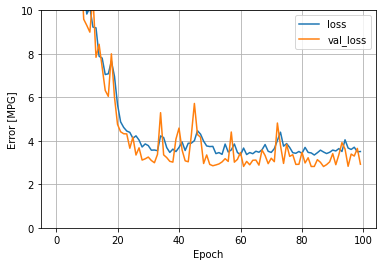

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

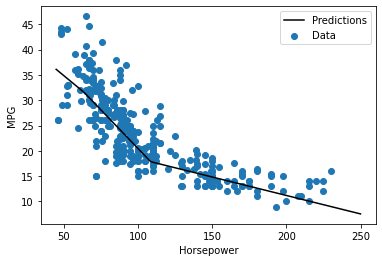

In [24]:
x = tf.linspace(45, 250, 251)
y = dnn_horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)